# Multi-Task Learning using Uncertainty Weighted Loss 

Multi-task learning is popular in many deep learning applications. For example, in object detection the network performs both classification and localization for each object. As a result, the final loss will be a combination of classification loss and regression loss. The most frequent way of combining two losses is by simply adding them together: 

$loss_{total} = loss_1 + loss_2$

However, a problem emerges when the two losses are on different numerical scales. To resolve this issue, people usually manually design/experimentally determine the best weight, which is very time consuming and computationally expensive:

$loss_{total} = w_1loss_1 + w_2loss_2$

[This paper](https://arxiv.org/abs/1705.07115) presents an interesting idea: make the weights w1 and w2 trainable parameters based on the uncertainty of each task, such that the network can dynamically focus more on the task with higher uncertainty.

In [1]:
import os
import tempfile

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.nn.init import kaiming_normal_ as he_normal
from torchvision import models

import fastestimator as fe
from fastestimator.backend import reduce_mean
from fastestimator.op.numpyop import Delete
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, LongestMaxSize, PadIfNeeded, ReadMat, ShiftScaleRotate
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize, ReadImage, Reshape
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy, Dice

In [2]:
#parameters
epochs = 25
batch_size = 8
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
data_dir = None

In [3]:
# Parameters
epochs = 2
batch_size = 8
max_train_steps_per_epoch = 10
max_eval_steps_per_epoch = 10


## Building Components

### Dataset

We will use the [CUB200 2010 dataset](http://www.vision.caltech.edu/visipedia/CUB-200.html) by Caltech. It contains 6033 bird images from 200 categories, where each image also has a corresponding mask. Therefore, our task is to classify and segment the bird given the image.

We use a FastEstimator API to load the CUB200 dataset and split the dataset to get train, evaluation and test sets.

In [4]:
from fastestimator.dataset.data import cub200

train_data = cub200.load_data(root_dir=data_dir)
eval_data = train_data.split(0.3)
test_data = eval_data.split(0.5) 

  0% [                                                  ]      0.20 / 679.42 MB

  0% [                                                  ]      0.56 / 679.42 MB

  0% [                                                  ]      0.94 / 679.42 MB

  0% [                                                  ]      1.26 / 679.42 MB

  0% [                                                  ]      1.70 / 679.42 MB

  0% [                                                  ]      2.03 / 679.42 MB

  0% [                                                  ]      2.41 / 679.42 MB

  0% [                                                  ]      2.74 / 679.42 MB

  0% [                                                  ]      3.13 / 679.42 MB

  0% [                                                  ]      3.46 / 679.42 MB

  0% [                                                  ]      3.78 / 679.42 MB

  0% [                                                  ]      4.18 / 679.42 MB

  0% [                                                  ]      4.52 / 679.42 MB

  0% [                                                  ]      4.88 / 679.42 MB

  0% [                                                  ]      5.23 / 679.42 MB

  0% [                                                  ]      5.56 / 679.42 MB

  0% [                                                  ]      5.95 / 679.42 MB

  0% [                                                  ]      6.31 / 679.42 MB

  0% [                                                  ]      6.67 / 679.42 MB

  1% [                                                  ]      7.03 / 679.42 MB

  1% [                                                  ]      7.31 / 679.42 MB

  1% [                                                  ]      7.69 / 679.42 MB

  1% [                                                  ]      8.06 / 679.42 MB

  1% [                                                  ]      8.41 / 679.42 MB

  1% [                                                  ]      8.76 / 679.42 MB

  1% [                                                  ]      9.11 / 679.42 MB

  1% [                                                  ]      9.44 / 679.42 MB

  1% [                                                  ]      9.75 / 679.42 MB

  1% [                                                  ]     10.06 / 679.42 MB

  1% [                                                  ]     10.44 / 679.42 MB

  1% [                                                  ]     10.76 / 679.42 MB

  1% [                                                  ]     11.12 / 679.42 MB

  1% [                                                  ]     11.48 / 679.42 MB

  1% [                                                  ]     11.80 / 679.42 MB

  1% [                                                  ]     12.16 / 679.42 MB

  1% [                                                  ]     12.52 / 679.42 MB

  1% [                                                  ]     12.91 / 679.42 MB

  1% [                                                  ]     13.17 / 679.42 MB

  1% [                                                  ]     13.49 / 679.42 MB

  2% [.                                                 ]     13.80 / 679.42 MB

  2% [.                                                 ]     14.12 / 679.42 MB

  2% [.                                                 ]     14.44 / 679.42 MB

  2% [.                                                 ]     14.83 / 679.42 MB

  2% [.                                                 ]     15.21 / 679.42 MB

  2% [.                                                 ]     15.56 / 679.42 MB

  2% [.                                                 ]     15.91 / 679.42 MB

  2% [.                                                 ]     16.20 / 679.42 MB

  2% [.                                                 ]     16.52 / 679.42 MB

  2% [.                                                 ]     16.87 / 679.42 MB

  2% [.                                                 ]     17.23 / 679.42 MB

  2% [.                                                 ]     17.49 / 679.42 MB

  2% [.                                                 ]     17.80 / 679.42 MB

  2% [.                                                 ]     18.13 / 679.42 MB

  2% [.                                                 ]     18.45 / 679.42 MB

  2% [.                                                 ]     18.79 / 679.42 MB

  2% [.                                                 ]     19.13 / 679.42 MB

  2% [.                                                 ]     19.45 / 679.42 MB

  2% [.                                                 ]     19.78 / 679.42 MB

  2% [.                                                 ]     20.10 / 679.42 MB

  3% [.                                                 ]     20.42 / 679.42 MB

  3% [.                                                 ]     20.75 / 679.42 MB

  3% [.                                                 ]     21.12 / 679.42 MB

  3% [.                                                 ]     21.45 / 679.42 MB

  3% [.                                                 ]     21.82 / 679.42 MB

  3% [.                                                 ]     22.22 / 679.42 MB

  3% [.                                                 ]     22.55 / 679.42 MB

  3% [.                                                 ]     22.97 / 679.42 MB

  3% [.                                                 ]     23.31 / 679.42 MB

  3% [.                                                 ]     23.67 / 679.42 MB

  3% [.                                                 ]     24.02 / 679.42 MB

  3% [.                                                 ]     24.35 / 679.42 MB

  3% [.                                                 ]     24.71 / 679.42 MB

  3% [.                                                 ]     25.10 / 679.42 MB

  3% [.                                                 ]     25.46 / 679.42 MB

  3% [.                                                 ]     25.83 / 679.42 MB

  3% [.                                                 ]     26.16 / 679.42 MB

  3% [.                                                 ]     26.50 / 679.42 MB

  3% [.                                                 ]     26.84 / 679.42 MB

  4% [..                                                ]     27.21 / 679.42 MB

  4% [..                                                ]     27.51 / 679.42 MB

  4% [..                                                ]     27.80 / 679.42 MB

  4% [..                                                ]     28.11 / 679.42 MB

  4% [..                                                ]     28.51 / 679.42 MB

  4% [..                                                ]     28.82 / 679.42 MB

  4% [..                                                ]     29.17 / 679.42 MB

  4% [..                                                ]     29.48 / 679.42 MB

  4% [..                                                ]     29.97 / 679.42 MB

  4% [..                                                ]     30.54 / 679.42 MB

  4% [..                                                ]     31.01 / 679.42 MB

  4% [..                                                ]     31.50 / 679.42 MB

  4% [..                                                ]     31.97 / 679.42 MB

  4% [..                                                ]     32.44 / 679.42 MB

  4% [..                                                ]     32.91 / 679.42 MB

  4% [..                                                ]     33.46 / 679.42 MB

  5% [..                                                ]     33.97 / 679.42 MB

  5% [..                                                ]     34.50 / 679.42 MB

  5% [..                                                ]     35.11 / 679.42 MB

  5% [..                                                ]     35.73 / 679.42 MB

  5% [..                                                ]     36.31 / 679.42 MB

  5% [..                                                ]     36.92 / 679.42 MB

  5% [..                                                ]     37.58 / 679.42 MB

  5% [..                                                ]     38.22 / 679.42 MB

  5% [..                                                ]     38.88 / 679.42 MB

  5% [..                                                ]     39.57 / 679.42 MB

  5% [..                                                ]     40.24 / 679.42 MB

  6% [...                                               ]     40.98 / 679.42 MB

  6% [...                                               ]     41.73 / 679.42 MB

  6% [...                                               ]     42.48 / 679.42 MB

  6% [...                                               ]     43.24 / 679.42 MB

  6% [...                                               ]     44.00 / 679.42 MB

  6% [...                                               ]     44.79 / 679.42 MB

  6% [...                                               ]     45.62 / 679.42 MB

  6% [...                                               ]     46.44 / 679.42 MB

  6% [...                                               ]     47.28 / 679.42 MB

  7% [...                                               ]     48.17 / 679.42 MB

  7% [...                                               ]     49.02 / 679.42 MB

  7% [...                                               ]     49.93 / 679.42 MB

  7% [...                                               ]     50.85 / 679.42 MB

  7% [...                                               ]     51.76 / 679.42 MB

  7% [...                                               ]     52.71 / 679.42 MB

  7% [...                                               ]     53.64 / 679.42 MB

  8% [....                                              ]     54.60 / 679.42 MB

  8% [....                                              ]     55.59 / 679.42 MB

  8% [....                                              ]     56.59 / 679.42 MB

  8% [....                                              ]     57.60 / 679.42 MB

  8% [....                                              ]     58.62 / 679.42 MB

  8% [....                                              ]     59.66 / 679.42 MB

  8% [....                                              ]     60.72 / 679.42 MB

  9% [....                                              ]     61.82 / 679.42 MB

  9% [....                                              ]     62.89 / 679.42 MB

  9% [....                                              ]     63.96 / 679.42 MB

  9% [....                                              ]     65.09 / 679.42 MB

  9% [....                                              ]     66.22 / 679.42 MB

  9% [....                                              ]     67.38 / 679.42 MB

 10% [.....                                             ]     68.42 / 679.42 MB

 10% [.....                                             ]     69.26 / 679.42 MB

 10% [.....                                             ]     70.00 / 679.42 MB

 10% [.....                                             ]     70.65 / 679.42 MB

 10% [.....                                             ]     71.34 / 679.42 MB

 10% [.....                                             ]     72.02 / 679.42 MB

 10% [.....                                             ]     72.79 / 679.42 MB

 10% [.....                                             ]     73.51 / 679.42 MB

 10% [.....                                             ]     74.25 / 679.42 MB

 11% [.....                                             ]     75.04 / 679.42 MB

 11% [.....                                             ]     75.78 / 679.42 MB

 11% [.....                                             ]     76.60 / 679.42 MB

 11% [.....                                             ]     77.40 / 679.42 MB

 11% [.....                                             ]     78.21 / 679.42 MB

 11% [.....                                             ]     79.08 / 679.42 MB

 11% [.....                                             ]     79.92 / 679.42 MB

 11% [.....                                             ]     80.82 / 679.42 MB

 12% [......                                            ]     81.66 / 679.42 MB

 12% [......                                            ]     82.56 / 679.42 MB

 12% [......                                            ]     83.45 / 679.42 MB

 12% [......                                            ]     84.41 / 679.42 MB

 12% [......                                            ]     85.31 / 679.42 MB

 12% [......                                            ]     86.28 / 679.42 MB

 12% [......                                            ]     87.26 / 679.42 MB

 12% [......                                            ]     88.24 / 679.42 MB

 13% [......                                            ]     89.26 / 679.42 MB

 13% [......                                            ]     90.18 / 679.42 MB

 13% [......                                            ]     91.14 / 679.42 MB

 13% [......                                            ]     92.21 / 679.42 MB

 13% [......                                            ]     93.19 / 679.42 MB

 13% [......                                            ]     94.26 / 679.42 MB

 14% [.......                                           ]     95.34 / 679.42 MB

 14% [.......                                           ]     96.31 / 679.42 MB

 14% [.......                                           ]     97.32 / 679.42 MB

 14% [.......                                           ]     98.39 / 679.42 MB

 14% [.......                                           ]     99.51 / 679.42 MB

 14% [.......                                           ]    100.66 / 679.42 MB

 14% [.......                                           ]    101.83 / 679.42 MB

 15% [.......                                           ]    102.98 / 679.42 MB

 15% [.......                                           ]    104.20 / 679.42 MB

 15% [.......                                           ]    105.46 / 679.42 MB

 15% [.......                                           ]    106.68 / 679.42 MB

 15% [.......                                           ]    107.95 / 679.42 MB

 16% [........                                          ]    109.21 / 679.42 MB

 16% [........                                          ]    110.46 / 679.42 MB

 16% [........                                          ]    111.74 / 679.42 MB

 16% [........                                          ]    113.08 / 679.42 MB

 16% [........                                          ]    114.44 / 679.42 MB

 17% [........                                          ]    115.78 / 679.42 MB

 17% [........                                          ]    117.18 / 679.42 MB

 17% [........                                          ]    118.55 / 679.42 MB

 17% [........                                          ]    119.96 / 679.42 MB

 17% [........                                          ]    121.40 / 679.42 MB

 18% [.........                                         ]    122.89 / 679.42 MB

 18% [.........                                         ]    124.48 / 679.42 MB

 18% [.........                                         ]    126.02 / 679.42 MB

 18% [.........                                         ]    127.62 / 679.42 MB

 19% [.........                                         ]    129.30 / 679.42 MB

 19% [.........                                         ]    131.08 / 679.42 MB

 19% [.........                                         ]    132.50 / 679.42 MB

 19% [.........                                         ]    133.90 / 679.42 MB

 19% [.........                                         ]    135.37 / 679.42 MB

 20% [..........                                        ]    136.89 / 679.42 MB

 20% [..........                                        ]    138.50 / 679.42 MB

 20% [..........                                        ]    140.09 / 679.42 MB

 20% [..........                                        ]    141.74 / 679.42 MB

 21% [..........                                        ]    143.42 / 679.42 MB

 21% [..........                                        ]    145.12 / 679.42 MB

 21% [..........                                        ]    146.82 / 679.42 MB

 21% [..........                                        ]    148.52 / 679.42 MB

 22% [...........                                       ]    150.25 / 679.42 MB

 22% [...........                                       ]    152.00 / 679.42 MB

 22% [...........                                       ]    153.74 / 679.42 MB

 22% [...........                                       ]    155.22 / 679.42 MB

 23% [...........                                       ]    156.39 / 679.42 MB

 23% [...........                                       ]    157.35 / 679.42 MB

 23% [...........                                       ]    158.35 / 679.42 MB

 23% [...........                                       ]    159.35 / 679.42 MB

 23% [...........                                       ]    160.32 / 679.42 MB

 23% [...........                                       ]    161.41 / 679.42 MB

 23% [...........                                       ]    162.43 / 679.42 MB

 24% [............                                      ]    163.40 / 679.42 MB

 24% [............                                      ]    164.14 / 679.42 MB

 24% [............                                      ]    164.96 / 679.42 MB

 24% [............                                      ]    165.72 / 679.42 MB

 24% [............                                      ]    166.51 / 679.42 MB

 24% [............                                      ]    167.38 / 679.42 MB

 24% [............                                      ]    168.21 / 679.42 MB

 24% [............                                      ]    169.07 / 679.42 MB

 24% [............                                      ]    169.84 / 679.42 MB

 25% [............                                      ]    170.76 / 679.42 MB

 25% [............                                      ]    171.60 / 679.42 MB

 25% [............                                      ]    172.52 / 679.42 MB

 25% [............                                      ]    173.39 / 679.42 MB

 25% [............                                      ]    174.23 / 679.42 MB

 25% [............                                      ]    174.89 / 679.42 MB

 25% [............                                      ]    175.57 / 679.42 MB

 25% [............                                      ]    176.30 / 679.42 MB

 26% [.............                                     ]    177.04 / 679.42 MB

 26% [.............                                     ]    177.82 / 679.42 MB

 26% [.............                                     ]    178.60 / 679.42 MB

 26% [.............                                     ]    179.43 / 679.42 MB

 26% [.............                                     ]    180.25 / 679.42 MB

 26% [.............                                     ]    181.13 / 679.42 MB

 26% [.............                                     ]    181.96 / 679.42 MB

 26% [.............                                     ]    182.79 / 679.42 MB

 27% [.............                                     ]    183.67 / 679.42 MB

 27% [.............                                     ]    184.53 / 679.42 MB

 27% [.............                                     ]    185.50 / 679.42 MB

 27% [.............                                     ]    186.36 / 679.42 MB

 27% [.............                                     ]    187.33 / 679.42 MB

 27% [.............                                     ]    188.28 / 679.42 MB

 27% [.............                                     ]    189.19 / 679.42 MB

 27% [.............                                     ]    190.17 / 679.42 MB

 28% [..............                                    ]    191.09 / 679.42 MB

 28% [..............                                    ]    192.06 / 679.42 MB

 28% [..............                                    ]    193.02 / 679.42 MB

 28% [..............                                    ]    193.99 / 679.42 MB

 28% [..............                                    ]    194.99 / 679.42 MB

 28% [..............                                    ]    195.98 / 679.42 MB

 28% [..............                                    ]    197.01 / 679.42 MB

 29% [..............                                    ]    198.07 / 679.42 MB

 29% [..............                                    ]    199.11 / 679.42 MB

 29% [..............                                    ]    200.10 / 679.42 MB

 29% [..............                                    ]    201.06 / 679.42 MB

 29% [..............                                    ]    201.85 / 679.42 MB

 29% [..............                                    ]    202.68 / 679.42 MB

 29% [..............                                    ]    203.50 / 679.42 MB

 30% [...............                                   ]    204.30 / 679.42 MB

 30% [...............                                   ]    205.16 / 679.42 MB

 30% [...............                                   ]    206.14 / 679.42 MB

 30% [...............                                   ]    207.06 / 679.42 MB

 30% [...............                                   ]    208.04 / 679.42 MB

 30% [...............                                   ]    209.06 / 679.42 MB

 30% [...............                                   ]    210.03 / 679.42 MB

 31% [...............                                   ]    211.12 / 679.42 MB

 31% [...............                                   ]    212.11 / 679.42 MB

 31% [...............                                   ]    213.20 / 679.42 MB

 31% [...............                                   ]    214.25 / 679.42 MB

 31% [...............                                   ]    215.36 / 679.42 MB

 31% [...............                                   ]    216.21 / 679.42 MB

 31% [...............                                   ]    217.03 / 679.42 MB

 32% [................                                  ]    217.81 / 679.42 MB

 32% [................                                  ]    218.65 / 679.42 MB

 32% [................                                  ]    219.49 / 679.42 MB

 32% [................                                  ]    220.36 / 679.42 MB

 32% [................                                  ]    221.22 / 679.42 MB

 32% [................                                  ]    222.12 / 679.42 MB

 32% [................                                  ]    222.99 / 679.42 MB

 32% [................                                  ]    223.91 / 679.42 MB

 33% [................                                  ]    224.85 / 679.42 MB

 33% [................                                  ]    225.77 / 679.42 MB

 33% [................                                  ]    226.75 / 679.42 MB

 33% [................                                  ]    227.71 / 679.42 MB

 33% [................                                  ]    228.68 / 679.42 MB

 33% [................                                  ]    229.62 / 679.42 MB

 33% [................                                  ]    230.63 / 679.42 MB

 34% [.................                                 ]    231.60 / 679.42 MB

 34% [.................                                 ]    232.64 / 679.42 MB

 34% [.................                                 ]    233.67 / 679.42 MB

 34% [.................                                 ]    234.73 / 679.42 MB

 34% [.................                                 ]    235.77 / 679.42 MB

 34% [.................                                 ]    236.85 / 679.42 MB

 35% [.................                                 ]    237.93 / 679.42 MB

 35% [.................                                 ]    239.04 / 679.42 MB

 35% [.................                                 ]    240.16 / 679.42 MB

 35% [.................                                 ]    241.31 / 679.42 MB

 35% [.................                                 ]    242.46 / 679.42 MB

 35% [.................                                 ]    243.61 / 679.42 MB

 36% [..................                                ]    244.82 / 679.42 MB

 36% [..................                                ]    246.01 / 679.42 MB

 36% [..................                                ]    247.25 / 679.42 MB

 36% [..................                                ]    248.46 / 679.42 MB

 36% [..................                                ]    249.71 / 679.42 MB

 36% [..................                                ]    250.96 / 679.42 MB

 37% [..................                                ]    252.25 / 679.42 MB

 37% [..................                                ]    253.55 / 679.42 MB

 37% [..................                                ]    254.84 / 679.42 MB

 37% [..................                                ]    256.16 / 679.42 MB

 37% [..................                                ]    257.49 / 679.42 MB

 38% [...................                               ]    258.83 / 679.42 MB

 38% [...................                               ]    260.19 / 679.42 MB

 38% [...................                               ]    261.57 / 679.42 MB

 38% [...................                               ]    262.96 / 679.42 MB

 38% [...................                               ]    264.02 / 679.42 MB

 39% [...................                               ]    265.24 / 679.42 MB

 39% [...................                               ]    266.28 / 679.42 MB

 39% [...................                               ]    267.42 / 679.42 MB

 39% [...................                               ]    268.53 / 679.42 MB

 39% [...................                               ]    269.72 / 679.42 MB

 39% [...................                               ]    270.92 / 679.42 MB

 40% [....................                              ]    272.12 / 679.42 MB

 40% [....................                              ]    272.97 / 679.42 MB

 40% [....................                              ]    274.12 / 679.42 MB

 40% [....................                              ]    275.06 / 679.42 MB

 40% [....................                              ]    276.02 / 679.42 MB

 40% [....................                              ]    277.00 / 679.42 MB

 40% [....................                              ]    277.97 / 679.42 MB

 41% [....................                              ]    278.98 / 679.42 MB

 41% [....................                              ]    279.95 / 679.42 MB

 41% [....................                              ]    280.86 / 679.42 MB

 41% [....................                              ]    281.56 / 679.42 MB

 41% [....................                              ]    282.35 / 679.42 MB

 41% [....................                              ]    283.05 / 679.42 MB

 41% [....................                              ]    283.82 / 679.42 MB

 41% [....................                              ]    284.55 / 679.42 MB

 41% [....................                              ]    285.25 / 679.42 MB

 42% [.....................                             ]    285.82 / 679.42 MB

 42% [.....................                             ]    286.43 / 679.42 MB

 42% [.....................                             ]    287.06 / 679.42 MB

 42% [.....................                             ]    287.73 / 679.42 MB

 42% [.....................                             ]    288.38 / 679.42 MB

 42% [.....................                             ]    289.05 / 679.42 MB

 42% [.....................                             ]    289.74 / 679.42 MB

 42% [.....................                             ]    290.46 / 679.42 MB

 42% [.....................                             ]    291.16 / 679.42 MB

 42% [.....................                             ]    291.88 / 679.42 MB

 43% [.....................                             ]    292.64 / 679.42 MB

 43% [.....................                             ]    293.39 / 679.42 MB

 43% [.....................                             ]    294.13 / 679.42 MB

 43% [.....................                             ]    294.92 / 679.42 MB

 43% [.....................                             ]    295.78 / 679.42 MB

 43% [.....................                             ]    296.59 / 679.42 MB

 43% [.....................                             ]    297.42 / 679.42 MB

 43% [.....................                             ]    298.34 / 679.42 MB

 44% [......................                            ]    299.19 / 679.42 MB

 44% [......................                            ]    300.08 / 679.42 MB

 44% [......................                            ]    301.02 / 679.42 MB

 44% [......................                            ]    301.96 / 679.42 MB

 44% [......................                            ]    302.91 / 679.42 MB

 44% [......................                            ]    303.86 / 679.42 MB

 44% [......................                            ]    304.80 / 679.42 MB

 44% [......................                            ]    305.73 / 679.42 MB

 45% [......................                            ]    306.75 / 679.42 MB

 45% [......................                            ]    307.74 / 679.42 MB

 45% [......................                            ]    308.80 / 679.42 MB

 45% [......................                            ]    309.85 / 679.42 MB

 45% [......................                            ]    310.82 / 679.42 MB

 45% [......................                            ]    311.65 / 679.42 MB

 45% [......................                            ]    312.52 / 679.42 MB

 46% [.......................                           ]    313.43 / 679.42 MB

 46% [.......................                           ]    314.23 / 679.42 MB

 46% [.......................                           ]    315.11 / 679.42 MB

 46% [.......................                           ]    316.09 / 679.42 MB

 46% [.......................                           ]    316.98 / 679.42 MB

 46% [.......................                           ]    318.01 / 679.42 MB

 46% [.......................                           ]    318.96 / 679.42 MB

 47% [.......................                           ]    319.96 / 679.42 MB

 47% [.......................                           ]    321.00 / 679.42 MB

 47% [.......................                           ]    321.99 / 679.42 MB

 47% [.......................                           ]    323.04 / 679.42 MB

 47% [.......................                           ]    324.07 / 679.42 MB

 47% [.......................                           ]    325.16 / 679.42 MB

 48% [........................                          ]    326.19 / 679.42 MB

 48% [........................                          ]    327.21 / 679.42 MB

 48% [........................                          ]    328.20 / 679.42 MB

 48% [........................                          ]    329.20 / 679.42 MB

 48% [........................                          ]    330.00 / 679.42 MB

 48% [........................                          ]    330.82 / 679.42 MB

 48% [........................                          ]    331.68 / 679.42 MB

 48% [........................                          ]    332.46 / 679.42 MB

 49% [........................                          ]    333.38 / 679.42 MB

 49% [........................                          ]    334.32 / 679.42 MB

 49% [........................                          ]    335.20 / 679.42 MB

 49% [........................                          ]    336.19 / 679.42 MB

 49% [........................                          ]    337.15 / 679.42 MB

 49% [........................                          ]    338.15 / 679.42 MB

 49% [........................                          ]    339.14 / 679.42 MB

 50% [.........................                         ]    340.15 / 679.42 MB

 50% [.........................                         ]    341.17 / 679.42 MB

 50% [.........................                         ]    342.13 / 679.42 MB

 50% [.........................                         ]    343.25 / 679.42 MB

 50% [.........................                         ]    344.30 / 679.42 MB

 50% [.........................                         ]    345.34 / 679.42 MB

 50% [.........................                         ]    346.46 / 679.42 MB

 51% [.........................                         ]    347.49 / 679.42 MB

 51% [.........................                         ]    348.56 / 679.42 MB

 51% [.........................                         ]    349.62 / 679.42 MB

 51% [.........................                         ]    350.70 / 679.42 MB

 51% [.........................                         ]    351.73 / 679.42 MB

 51% [.........................                         ]    352.80 / 679.42 MB

 52% [..........................                        ]    353.90 / 679.42 MB

 52% [..........................                        ]    355.04 / 679.42 MB

 52% [..........................                        ]    356.16 / 679.42 MB

 52% [..........................                        ]    357.36 / 679.42 MB

 52% [..........................                        ]    358.50 / 679.42 MB

 52% [..........................                        ]    359.73 / 679.42 MB

 53% [..........................                        ]    360.91 / 679.42 MB

 53% [..........................                        ]    362.14 / 679.42 MB

 53% [..........................                        ]    363.32 / 679.42 MB

 53% [..........................                        ]    364.62 / 679.42 MB

 53% [..........................                        ]    365.86 / 679.42 MB

 54% [...........................                       ]    367.10 / 679.42 MB

 54% [...........................                       ]    368.40 / 679.42 MB

 54% [...........................                       ]    369.70 / 679.42 MB

 54% [...........................                       ]    371.06 / 679.42 MB

 54% [...........................                       ]    372.36 / 679.42 MB

 55% [...........................                       ]    373.75 / 679.42 MB

 55% [...........................                       ]    375.12 / 679.42 MB

 55% [...........................                       ]    376.54 / 679.42 MB

 55% [...........................                       ]    377.93 / 679.42 MB

 55% [...........................                       ]    379.38 / 679.42 MB

 56% [............................                      ]    380.79 / 679.42 MB

 56% [............................                      ]    382.26 / 679.42 MB

 56% [............................                      ]    383.65 / 679.42 MB

 56% [............................                      ]    385.06 / 679.42 MB

 56% [............................                      ]    386.56 / 679.42 MB

 57% [............................                      ]    388.06 / 679.42 MB

 57% [............................                      ]    389.62 / 679.42 MB

 57% [............................                      ]    391.14 / 679.42 MB

 57% [............................                      ]    392.71 / 679.42 MB

 58% [.............................                     ]    394.31 / 679.42 MB

 58% [.............................                     ]    395.89 / 679.42 MB

 58% [.............................                     ]    397.66 / 679.42 MB

 58% [.............................                     ]    399.41 / 679.42 MB

 59% [.............................                     ]    401.22 / 679.42 MB

 59% [.............................                     ]    403.10 / 679.42 MB

 59% [.............................                     ]    405.05 / 679.42 MB

 59% [.............................                     ]    407.09 / 679.42 MB

 60% [..............................                    ]    408.59 / 679.42 MB

 60% [..............................                    ]    410.07 / 679.42 MB

 60% [..............................                    ]    411.12 / 679.42 MB

 60% [..............................                    ]    412.42 / 679.42 MB

 60% [..............................                    ]    413.56 / 679.42 MB

 61% [..............................                    ]    414.71 / 679.42 MB

 61% [..............................                    ]    415.96 / 679.42 MB

 61% [..............................                    ]    417.17 / 679.42 MB

 61% [..............................                    ]    418.42 / 679.42 MB

 61% [..............................                    ]    419.73 / 679.42 MB

 61% [..............................                    ]    420.71 / 679.42 MB

 62% [...............................                   ]    421.72 / 679.42 MB

 62% [...............................                   ]    422.65 / 679.42 MB

 62% [...............................                   ]    423.68 / 679.42 MB

 62% [...............................                   ]    424.57 / 679.42 MB

 62% [...............................                   ]    425.48 / 679.42 MB

 62% [...............................                   ]    426.20 / 679.42 MB

 62% [...............................                   ]    426.94 / 679.42 MB

 62% [...............................                   ]    427.76 / 679.42 MB

 63% [...............................                   ]    428.53 / 679.42 MB

 63% [...............................                   ]    429.41 / 679.42 MB

 63% [...............................                   ]    430.20 / 679.42 MB

 63% [...............................                   ]    430.96 / 679.42 MB

 63% [...............................                   ]    431.82 / 679.42 MB

 63% [...............................                   ]    432.71 / 679.42 MB

 63% [...............................                   ]    433.55 / 679.42 MB

 63% [...............................                   ]    434.41 / 679.42 MB

 64% [................................                  ]    435.33 / 679.42 MB

 64% [................................                  ]    436.26 / 679.42 MB

 64% [................................                  ]    437.18 / 679.42 MB

 64% [................................                  ]    438.13 / 679.42 MB

 64% [................................                  ]    439.13 / 679.42 MB

 64% [................................                  ]    440.07 / 679.42 MB

 64% [................................                  ]    441.07 / 679.42 MB

 65% [................................                  ]    442.05 / 679.42 MB

 65% [................................                  ]    443.15 / 679.42 MB

 65% [................................                  ]    444.13 / 679.42 MB

 65% [................................                  ]    445.16 / 679.42 MB

 65% [................................                  ]    446.27 / 679.42 MB

 65% [................................                  ]    447.31 / 679.42 MB

 66% [.................................                 ]    448.47 / 679.42 MB

 66% [.................................                 ]    449.58 / 679.42 MB

 66% [.................................                 ]    450.74 / 679.42 MB

 66% [.................................                 ]    451.92 / 679.42 MB

 66% [.................................                 ]    453.07 / 679.42 MB

 66% [.................................                 ]    454.25 / 679.42 MB

 67% [.................................                 ]    455.48 / 679.42 MB

 67% [.................................                 ]    456.67 / 679.42 MB

 67% [.................................                 ]    457.92 / 679.42 MB

 67% [.................................                 ]    459.08 / 679.42 MB

 67% [.................................                 ]    460.30 / 679.42 MB

 67% [.................................                 ]    461.59 / 679.42 MB

 68% [..................................                ]    462.93 / 679.42 MB

 68% [..................................                ]    464.21 / 679.42 MB

 68% [..................................                ]    465.50 / 679.42 MB

 68% [..................................                ]    466.36 / 679.42 MB

 68% [..................................                ]    467.49 / 679.42 MB

 68% [..................................                ]    468.46 / 679.42 MB

 69% [..................................                ]    469.53 / 679.42 MB

 69% [..................................                ]    470.55 / 679.42 MB

 69% [..................................                ]    471.73 / 679.42 MB

 69% [..................................                ]    472.78 / 679.42 MB

 69% [..................................                ]    473.98 / 679.42 MB

 69% [..................................                ]    475.11 / 679.42 MB

 70% [...................................               ]    475.99 / 679.42 MB

 70% [...................................               ]    476.89 / 679.42 MB

 70% [...................................               ]    477.78 / 679.42 MB

 70% [...................................               ]    478.74 / 679.42 MB

 70% [...................................               ]    479.68 / 679.42 MB

 70% [...................................               ]    480.69 / 679.42 MB

 70% [...................................               ]    481.67 / 679.42 MB

 71% [...................................               ]    482.64 / 679.42 MB

 71% [...................................               ]    483.62 / 679.42 MB

 71% [...................................               ]    484.59 / 679.42 MB

 71% [...................................               ]    485.60 / 679.42 MB

 71% [...................................               ]    486.60 / 679.42 MB

 71% [...................................               ]    487.64 / 679.42 MB

 71% [...................................               ]    488.64 / 679.42 MB

 72% [....................................              ]    489.79 / 679.42 MB

 72% [....................................              ]    490.81 / 679.42 MB

 72% [....................................              ]    491.95 / 679.42 MB

 72% [....................................              ]    493.03 / 679.42 MB

 72% [....................................              ]    494.15 / 679.42 MB

 72% [....................................              ]    495.30 / 679.42 MB

 73% [....................................              ]    496.46 / 679.42 MB

 73% [....................................              ]    497.63 / 679.42 MB

 73% [....................................              ]    498.42 / 679.42 MB

 73% [....................................              ]    499.48 / 679.42 MB

 73% [....................................              ]    500.19 / 679.42 MB

 73% [....................................              ]    500.86 / 679.42 MB

 73% [....................................              ]    501.48 / 679.42 MB

 73% [....................................              ]    502.23 / 679.42 MB

 74% [.....................................             ]    502.98 / 679.42 MB

 74% [.....................................             ]    503.72 / 679.42 MB

 74% [.....................................             ]    504.41 / 679.42 MB

 74% [.....................................             ]    505.17 / 679.42 MB

 74% [.....................................             ]    505.89 / 679.42 MB

 74% [.....................................             ]    506.65 / 679.42 MB

 74% [.....................................             ]    507.43 / 679.42 MB

 74% [.....................................             ]    508.21 / 679.42 MB

 74% [.....................................             ]    509.00 / 679.42 MB

 75% [.....................................             ]    509.88 / 679.42 MB

 75% [.....................................             ]    510.67 / 679.42 MB

 75% [.....................................             ]    511.57 / 679.42 MB

 75% [.....................................             ]    512.45 / 679.42 MB

 75% [.....................................             ]    513.34 / 679.42 MB

 75% [.....................................             ]    514.28 / 679.42 MB

 75% [.....................................             ]    515.13 / 679.42 MB

 75% [.....................................             ]    516.13 / 679.42 MB

 76% [......................................            ]    517.11 / 679.42 MB

 76% [......................................            ]    518.01 / 679.42 MB

 76% [......................................            ]    518.89 / 679.42 MB

 76% [......................................            ]    519.91 / 679.42 MB

 76% [......................................            ]    520.89 / 679.42 MB

 76% [......................................            ]    521.91 / 679.42 MB

 76% [......................................            ]    522.97 / 679.42 MB

 77% [......................................            ]    524.06 / 679.42 MB

 77% [......................................            ]    525.05 / 679.42 MB

 77% [......................................            ]    526.00 / 679.42 MB

 77% [......................................            ]    526.75 / 679.42 MB

 77% [......................................            ]    527.61 / 679.42 MB

 77% [......................................            ]    528.50 / 679.42 MB

 77% [......................................            ]    529.38 / 679.42 MB

 78% [.......................................           ]    530.30 / 679.42 MB

 78% [.......................................           ]    531.23 / 679.42 MB

 78% [.......................................           ]    532.23 / 679.42 MB

 78% [.......................................           ]    533.22 / 679.42 MB

 78% [.......................................           ]    534.23 / 679.42 MB

 78% [.......................................           ]    535.25 / 679.42 MB

 78% [.......................................           ]    536.28 / 679.42 MB

 79% [.......................................           ]    537.34 / 679.42 MB

 79% [.......................................           ]    538.39 / 679.42 MB

 79% [.......................................           ]    539.44 / 679.42 MB

 79% [.......................................           ]    540.52 / 679.42 MB

 79% [.......................................           ]    541.57 / 679.42 MB

 79% [.......................................           ]    542.65 / 679.42 MB

 80% [........................................          ]    543.78 / 679.42 MB

 80% [........................................          ]    544.83 / 679.42 MB

 80% [........................................          ]    545.93 / 679.42 MB

 80% [........................................          ]    547.00 / 679.42 MB

 80% [........................................          ]    548.09 / 679.42 MB

 80% [........................................          ]    549.16 / 679.42 MB

 80% [........................................          ]    550.26 / 679.42 MB

 81% [........................................          ]    551.38 / 679.42 MB

 81% [........................................          ]    552.50 / 679.42 MB

 81% [........................................          ]    553.36 / 679.42 MB

 81% [........................................          ]    554.36 / 679.42 MB

 81% [........................................          ]    555.32 / 679.42 MB

 81% [........................................          ]    556.30 / 679.42 MB

 82% [.........................................         ]    557.20 / 679.42 MB

 82% [.........................................         ]    558.19 / 679.42 MB

 82% [.........................................         ]    559.19 / 679.42 MB

 82% [.........................................         ]    560.23 / 679.42 MB

 82% [.........................................         ]    561.31 / 679.42 MB

 82% [.........................................         ]    562.38 / 679.42 MB

 82% [.........................................         ]    563.47 / 679.42 MB

 83% [.........................................         ]    564.41 / 679.42 MB

 83% [.........................................         ]    565.31 / 679.42 MB

 83% [.........................................         ]    566.15 / 679.42 MB

 83% [.........................................         ]    567.02 / 679.42 MB

 83% [.........................................         ]    567.86 / 679.42 MB

 83% [.........................................         ]    568.74 / 679.42 MB

 83% [.........................................         ]    569.61 / 679.42 MB

 83% [.........................................         ]    570.52 / 679.42 MB

 84% [..........................................        ]    571.40 / 679.42 MB

 84% [..........................................        ]    572.33 / 679.42 MB

 84% [..........................................        ]    573.24 / 679.42 MB

 84% [..........................................        ]    573.93 / 679.42 MB

 84% [..........................................        ]    574.61 / 679.42 MB

 84% [..........................................        ]    575.30 / 679.42 MB

 84% [..........................................        ]    576.00 / 679.42 MB

 84% [..........................................        ]    576.72 / 679.42 MB

 84% [..........................................        ]    577.47 / 679.42 MB

 85% [..........................................        ]    578.21 / 679.42 MB

 85% [..........................................        ]    579.00 / 679.42 MB

 85% [..........................................        ]    579.79 / 679.42 MB

 85% [..........................................        ]    580.56 / 679.42 MB

 85% [..........................................        ]    581.41 / 679.42 MB

 85% [..........................................        ]    582.22 / 679.42 MB

 85% [..........................................        ]    583.06 / 679.42 MB

 85% [..........................................        ]    583.94 / 679.42 MB

 86% [...........................................       ]    584.78 / 679.42 MB

 86% [...........................................       ]    585.67 / 679.42 MB

 86% [...........................................       ]    586.58 / 679.42 MB

 86% [...........................................       ]    587.50 / 679.42 MB

 86% [...........................................       ]    588.47 / 679.42 MB

 86% [...........................................       ]    589.42 / 679.42 MB

 86% [...........................................       ]    590.36 / 679.42 MB

 87% [...........................................       ]    591.31 / 679.42 MB

 87% [...........................................       ]    592.31 / 679.42 MB

 87% [...........................................       ]    593.28 / 679.42 MB

 87% [...........................................       ]    594.35 / 679.42 MB

 87% [...........................................       ]    595.41 / 679.42 MB

 87% [...........................................       ]    596.43 / 679.42 MB

 87% [...........................................       ]    597.48 / 679.42 MB

 88% [............................................      ]    598.53 / 679.42 MB

 88% [............................................      ]    599.74 / 679.42 MB

 88% [............................................      ]    600.88 / 679.42 MB

 88% [............................................      ]    601.96 / 679.42 MB

 88% [............................................      ]    603.16 / 679.42 MB

 88% [............................................      ]    604.31 / 679.42 MB

 89% [............................................      ]    605.50 / 679.42 MB

 89% [............................................      ]    606.72 / 679.42 MB

 89% [............................................      ]    607.90 / 679.42 MB

 89% [............................................      ]    609.13 / 679.42 MB

 89% [............................................      ]    610.33 / 679.42 MB

 90% [.............................................     ]    611.60 / 679.42 MB

 90% [.............................................     ]    612.87 / 679.42 MB

 90% [.............................................     ]    614.16 / 679.42 MB

 90% [.............................................     ]    615.45 / 679.42 MB

 90% [.............................................     ]    616.82 / 679.42 MB

 90% [.............................................     ]    618.15 / 679.42 MB

 91% [.............................................     ]    619.46 / 679.42 MB

 91% [.............................................     ]    620.38 / 679.42 MB

 91% [.............................................     ]    621.36 / 679.42 MB

 91% [.............................................     ]    622.45 / 679.42 MB

 91% [.............................................     ]    623.30 / 679.42 MB

 91% [.............................................     ]    623.95 / 679.42 MB

 91% [.............................................     ]    624.47 / 679.42 MB

 91% [.............................................     ]    624.96 / 679.42 MB

 92% [..............................................    ]    625.34 / 679.42 MB

 92% [..............................................    ]    625.54 / 679.42 MB

 92% [..............................................    ]    625.88 / 679.42 MB

 92% [..............................................    ]    626.22 / 679.42 MB

 92% [..............................................    ]    626.73 / 679.42 MB

 92% [..............................................    ]    627.11 / 679.42 MB

 92% [..............................................    ]    627.52 / 679.42 MB

 92% [..............................................    ]    627.88 / 679.42 MB

 92% [..............................................    ]    628.22 / 679.42 MB

 92% [..............................................    ]    628.71 / 679.42 MB

 92% [..............................................    ]    629.08 / 679.42 MB

 92% [..............................................    ]    629.19 / 679.42 MB

 92% [..............................................    ]    629.60 / 679.42 MB

 92% [..............................................    ]    630.00 / 679.42 MB

 92% [..............................................    ]    630.50 / 679.42 MB

 92% [..............................................    ]    630.86 / 679.42 MB

 92% [..............................................    ]    631.40 / 679.42 MB

 93% [..............................................    ]    631.88 / 679.42 MB

 93% [..............................................    ]    632.42 / 679.42 MB

 93% [..............................................    ]    633.01 / 679.42 MB

 93% [..............................................    ]    633.60 / 679.42 MB

 93% [..............................................    ]    634.21 / 679.42 MB

 93% [..............................................    ]    634.81 / 679.42 MB

 93% [..............................................    ]    635.44 / 679.42 MB

 93% [..............................................    ]    636.08 / 679.42 MB

 93% [..............................................    ]    636.72 / 679.42 MB

 93% [..............................................    ]    637.33 / 679.42 MB

 93% [..............................................    ]    637.92 / 679.42 MB

 93% [..............................................    ]    638.62 / 679.42 MB

 94% [...............................................   ]    639.34 / 679.42 MB

 94% [...............................................   ]    640.07 / 679.42 MB

 94% [...............................................   ]    640.75 / 679.42 MB

 94% [...............................................   ]    641.47 / 679.42 MB

 94% [...............................................   ]    642.22 / 679.42 MB

 94% [...............................................   ]    642.96 / 679.42 MB

 94% [...............................................   ]    643.75 / 679.42 MB

 94% [...............................................   ]    644.48 / 679.42 MB

 94% [...............................................   ]    645.29 / 679.42 MB

 95% [...............................................   ]    646.07 / 679.42 MB

 95% [...............................................   ]    646.91 / 679.42 MB

 95% [...............................................   ]    647.78 / 679.42 MB

 95% [...............................................   ]    648.37 / 679.42 MB

 95% [...............................................   ]    648.98 / 679.42 MB

 95% [...............................................   ]    649.69 / 679.42 MB

 95% [...............................................   ]    650.44 / 679.42 MB

 95% [...............................................   ]    651.21 / 679.42 MB

 95% [...............................................   ]    652.02 / 679.42 MB

 96% [................................................  ]    652.81 / 679.42 MB

 96% [................................................  ]    653.52 / 679.42 MB

 96% [................................................  ]    654.29 / 679.42 MB

 96% [................................................  ]    655.11 / 679.42 MB

 96% [................................................  ]    655.91 / 679.42 MB

 96% [................................................  ]    656.76 / 679.42 MB

 96% [................................................  ]    657.60 / 679.42 MB

 96% [................................................  ]    658.44 / 679.42 MB

 97% [................................................  ]    659.29 / 679.42 MB

 97% [................................................  ]    660.15 / 679.42 MB

 97% [................................................  ]    661.01 / 679.42 MB

 97% [................................................  ]    661.85 / 679.42 MB

 97% [................................................  ]    662.64 / 679.42 MB

 97% [................................................  ]    663.59 / 679.42 MB

 97% [................................................  ]    664.49 / 679.42 MB

 97% [................................................  ]    665.43 / 679.42 MB

 98% [................................................. ]    666.40 / 679.42 MB

 98% [................................................. ]    667.34 / 679.42 MB

 98% [................................................. ]    668.26 / 679.42 MB

 98% [................................................. ]    669.34 / 679.42 MB

 98% [................................................. ]    670.40 / 679.42 MB

 98% [................................................. ]    671.39 / 679.42 MB

 98% [................................................. ]    672.46 / 679.42 MB

 99% [................................................. ]    673.54 / 679.42 MB

 99% [................................................. ]    674.55 / 679.42 MB

 99% [................................................. ]    675.64 / 679.42 MB

 99% [................................................. ]    676.71 / 679.42 MB

 99% [................................................. ]    677.86 / 679.42 MB

 99% [................................................. ]    678.96 / 679.42 MB

100% [..................................................]    679.42 / 679.42 MB


  1% [                                                    ]     0.21 / 11.53 MB

  5% [..                                                  ]     0.59 / 11.53 MB

  7% [....                                                ]     0.89 / 11.53 MB

 10% [.....                                               ]     1.25 / 11.53 MB

 13% [......                                              ]     1.50 / 11.53 MB

 16% [........                                            ]     1.86 / 11.53 MB

 19% [..........                                          ]     2.22 / 11.53 MB

 22% [...........                                         ]     2.55 / 11.53 MB

 25% [.............                                       ]     2.92 / 11.53 MB

 28% [..............                                      ]     3.24 / 11.53 MB

 30% [................                                    ]     3.56 / 11.53 MB

 33% [.................                                   ]     3.87 / 11.53 MB

 36% [..................                                  ]     4.21 / 11.53 MB

 39% [....................                                ]     4.55 / 11.53 MB

 42% [.....................                               ]     4.87 / 11.53 MB

 45% [.......................                             ]     5.23 / 11.53 MB

 48% [.........................                           ]     5.56 / 11.53 MB

 50% [..........................                          ]     5.86 / 11.53 MB

 53% [............................                        ]     6.21 / 11.53 MB

 56% [.............................                       ]     6.55 / 11.53 MB

 60% [...............................                     ]     6.92 / 11.53 MB

 62% [................................                    ]     7.25 / 11.53 MB

 66% [..................................                  ]     7.63 / 11.53 MB

 68% [...................................                 ]     7.94 / 11.53 MB

 71% [.....................................               ]     8.22 / 11.53 MB

 74% [......................................              ]     8.56 / 11.53 MB

 77% [........................................            ]     8.91 / 11.53 MB

 80% [.........................................           ]     9.23 / 11.53 MB

 83% [...........................................         ]     9.58 / 11.53 MB

 86% [............................................        ]     9.95 / 11.53 MB

 89% [..............................................      ]    10.27 / 11.53 MB

 92% [...............................................     ]    10.63 / 11.53 MB

 95% [.................................................   ]    10.99 / 11.53 MB

 98% [................................................... ]    11.32 / 11.53 MB

100% [....................................................]    11.53 / 11.53 MB

Extracting files ...


Data summary is saved at /home/geez219/fastestimator_data/CUB200/cub200.csv


### Step 1: Create `Pipeline`

We read the images with `ReadImage`, and the masks stored in a MAT file with `ReadMat`. There is other information stored in the MAT file, so we specify the key `seg` to retrieve the mask only.

Here the main task is to resize the images and masks into 512 by 512 pixels. We use `LongestMaxSize` (to preserve the aspect ratio) and `PadIfNeeded` to resize the image. We will augment both image and mask in the same way and rescale the image pixel values between -1 and 1 since we are using pre-trained ImageNet weights.

In [5]:
pipeline = fe.Pipeline(batch_size=batch_size,
                       train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       ops=[
                           ReadImage(inputs="image",
                                     outputs="image",
                                     parent_path=train_data.parent_path),
                           Normalize(inputs="image",
                                     outputs="image",
                                     mean=1.0,
                                     std=1.0,
                                     max_pixel_value=127.5),
                           ReadMat(file='annotation',
                                   keys="seg",
                                   parent_path=train_data.parent_path),
                           Delete(keys="annotation"),
                           LongestMaxSize(max_size=512,
                                          image_in="image",
                                          image_out="image",
                                          mask_in="seg",
                                          mask_out="seg"),
                           PadIfNeeded(min_height=512,
                                       min_width=512,
                                       image_in="image",
                                       image_out="image",
                                       mask_in="seg",
                                       mask_out="seg",
                                       border_mode=cv2.BORDER_CONSTANT,
                                       value=0,
                                       mask_value=0),
                           ShiftScaleRotate(
                               image_in="image",
                               mask_in="seg",
                               image_out="image",
                               mask_out="seg",
                               mode="train",
                               shift_limit=0.2,
                               rotate_limit=15.0,
                               scale_limit=0.2,
                               border_mode=cv2.BORDER_CONSTANT,
                               value=0,
                               mask_value=0),
                           Sometimes(
                               HorizontalFlip(image_in="image",
                                              mask_in="seg",
                                              image_out="image",
                                              mask_out="seg",
                                              mode="train")),
                           ChannelTranspose(inputs="image",
                                            outputs="image"),
                           Reshape(shape=(1, 512, 512),
                                   inputs="seg",
                                   outputs="seg")
                       ])

### Let's visualize our `Pipeline` results

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def Minmax(data):
    data_max = np.max(data)
    data_min = np.min(data)
    data = (data - data_min) / max((data_max - data_min), 1e-7)
    return data


def visualize_image_mask(img, mask):
    img = (img*255).astype(np.uint8)
    
    mask = mask.astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    ret, mask_thres = cv2.threshold(mask, 0.5,1, cv2.THRESH_BINARY)
    mask_overlay = mask * mask_thres
    mask_overlay = np.where( mask_overlay != [0,0,0], [255,0,0] ,[0,0,0])
    mask_overlay = mask_overlay.astype(np.uint8)
    img_with_mask = cv2.addWeighted(img, 0.7, mask_overlay, 0.3,0 )

    maskgt_with_maskpred = cv2.addWeighted(mask, 0.7, mask_overlay, 0.3, 0)

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    ax[0].imshow(img)
    ax[0].set_title('original image')
    ax[1].imshow(img_with_mask)
    ax[1].set_title('img - mask overlay')
    plt.show()

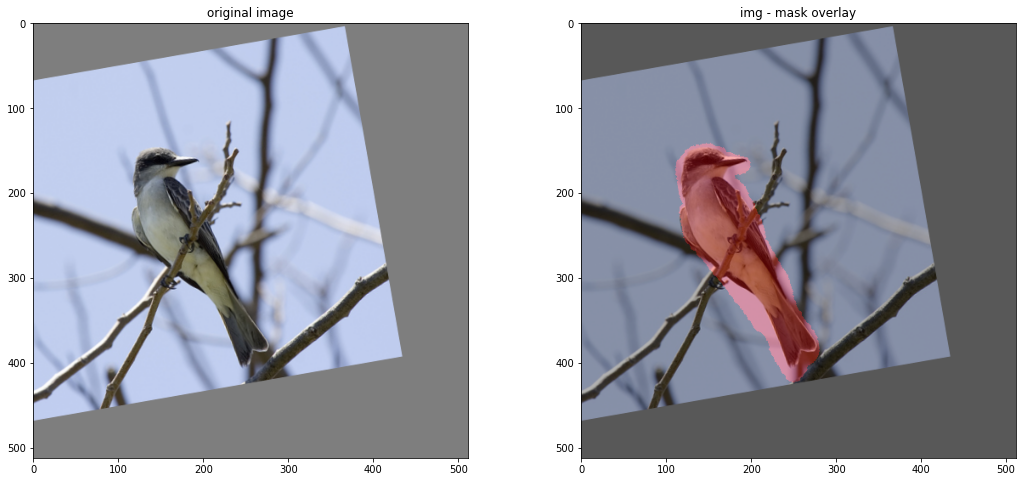

In [7]:
idx = np.random.randint(low=0, high=batch_size)
result = pipeline.get_results()
img = Minmax(result["image"][idx].numpy())
msk = np.squeeze(result["seg"][idx].numpy())
img = np.transpose(img, (1, 2, 0))

visualize_image_mask(img, msk)

### Step 2: Create `Network`
In this implementation, the network architecture is not the focus. Therefore, we are going to create something out of the blue :). How about a combination of resnet50 and Unet that can do both classification and segmentation? We can call it - ResUnet50 

In [8]:
class Upsample2D(nn.Module):
    """Upsampling Block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(mode="bilinear", scale_factor=2, align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        for l in self.upsample:
            if isinstance(l, nn.Conv2d):
                he_normal(l.weight.data)

    def forward(self, x):
        return self.upsample(x)


class DecBlock(nn.Module):
    """Decoder Block"""
    def __init__(self, upsample_in_ch, conv_in_ch, out_ch):
        super().__init__()
        self.upsample = Upsample2D(upsample_in_ch, out_ch)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(conv_in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        for l in self.conv_layers:
            if isinstance(l, nn.Conv2d):
                he_normal(l.weight.data)

    def forward(self, x_up, x_down):
        x = self.upsample(x_up)
        x = torch.cat([x, x_down], 1)
        x = self.conv_layers(x)
        return x


class ResUnet50(nn.Module):
    """Network Architecture"""
    def __init__(self, num_classes=200):
        super().__init__()
        base_model = models.resnet50(pretrained=True)

        self.enc1 = nn.Sequential(*list(base_model.children())[:3])
        self.input_pool = list(base_model.children())[3]
        self.enc2 = nn.Sequential(*list(base_model.children())[4])
        self.enc3 = nn.Sequential(*list(base_model.children())[5])
        self.enc4 = nn.Sequential(*list(base_model.children())[6])
        self.enc5 = nn.Sequential(*list(base_model.children())[7])
        self.fc = nn.Linear(2048, num_classes)

        self.dec6 = DecBlock(2048, 1536, 512)
        self.dec7 = DecBlock(512, 768, 256)
        self.dec8 = DecBlock(256, 384, 128)
        self.dec9 = DecBlock(128, 128, 64)
        self.dec10 = Upsample2D(64, 2)
        self.mask = nn.Conv2d(2, 1, kernel_size=1)

    def forward(self, x):
        x_e1 = self.enc1(x)
        x_e1_1 = self.input_pool(x_e1)
        x_e2 = self.enc2(x_e1_1)
        x_e3 = self.enc3(x_e2)
        x_e4 = self.enc4(x_e3)
        x_e5 = self.enc5(x_e4)

        x_label = fn.max_pool2d(x_e5, kernel_size=x_e5.size()[2:])
        x_label = x_label.view(x_label.shape[0], -1)
        x_label = self.fc(x_label)
        x_label = torch.softmax(x_label, dim=-1)

        x_d6 = self.dec6(x_e5, x_e4)
        x_d7 = self.dec7(x_d6, x_e3)
        x_d8 = self.dec8(x_d7, x_e2)
        x_d9 = self.dec9(x_d8, x_e1)
        x_d10 = self.dec10(x_d9)
        x_mask = self.mask(x_d10)
        x_mask = torch.sigmoid(x_mask)
        return x_label, x_mask

Other than the ResUnet50, we will have another network to contain the trainable weighted parameter in the weighted loss. We call it our uncertainty model. In the network `ops`, ResUnet50 produces both a predicted label and predicted mask. These two predictions are then fed to classification loss and segmentation loss operators respectively. Finally, both losses are passed to the uncertainty model to create a final loss.

In [9]:
class UncertaintyLossNet(nn.Module):
    """Creates Uncertainty weighted loss model https://arxiv.org/abs/1705.07115
    """
    def __init__(self):
        super().__init__()
        self.w1 = nn.Parameter(torch.zeros(1))
        self.w2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        loss = torch.exp(-self.w1) * x[0] + self.w1 + torch.exp(
            -self.w2) * x[1] + self.w2
        return loss

We also implement a `TensorOp` to average the output of `UncertaintyLossNet` for each batch:

In [10]:
class ReduceLoss(TensorOp):
    def forward(self, data, state):
        return reduce_mean(data)

In [11]:
resunet50 = fe.build(model_fn=ResUnet50,
                     model_name="resunet50",
                     optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-4))
uncertainty = fe.build(model_fn=UncertaintyLossNet,
                       model_name="uncertainty",
                       optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-5))

network = fe.Network(ops=[
    ModelOp(inputs='image',
            model=resunet50,
            outputs=["label_pred", "mask_pred"]),
    CrossEntropy(inputs=["label_pred", "label"],
                 outputs="cls_loss",
                 form="sparse",
                 average_loss=False),
    CrossEntropy(inputs=["mask_pred", "seg"],
                 outputs="seg_loss",
                 form="binary",
                 average_loss=False),
    ModelOp(inputs=["cls_loss", "seg_loss"],
            model=uncertainty,
            outputs="total_loss"),
    ReduceLoss(inputs="total_loss", outputs="total_loss"),
    UpdateOp(model=resunet50, loss_name="total_loss"),
    UpdateOp(model=uncertainty, loss_name="total_loss")
])

### Step 3: Create `Estimator`

We will have four different traces to control/monitor the training: `Dice` and `Accuracy` will be used to measure segmentation and classification results, `BestModelSaver` will save the model with best loss, and `LRScheduler` will apply a cosine learning rate decay throughout the training loop.

In [12]:
traces = [
    Accuracy(true_key="label", pred_key="label_pred"),
    Dice(true_key="seg", pred_key='mask_pred'),
    BestModelSaver(model=resunet50,
                   save_dir=save_dir,
                   metric="total_loss",
                   save_best_mode="min"),
    LRScheduler(model=resunet50,
                lr_fn=lambda step: cosine_decay(
                    step, cycle_length=13200, init_lr=1e-4))
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         traces=traces,
                         epochs=epochs,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                         log_steps=500)

## Training and Testing

The whole training (25 epochs) will take about 1 hour 20 mins on single V100 GPU. We are going to reach ~0.87 dice and ~83% accuracy by the end of the training.

In [13]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 


FastEstimator-Train: step: 1; total_loss: 9.546179; resunet50_lr: 1e-04; 


FastEstimator-Train: step: 10; epoch: 1; epoch_time: 194.28 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmpmgqvba6t/resunet50_best_total_loss.pt
FastEstimator-Eval: step: 10; epoch: 1; total_loss: 8.232448; accuracy: 0.0; Dice: 4.405018032541422e-13; since_best_total_loss: 0; min_total_loss: 8.232448; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 196.97 sec; 


FastEstimator-Eval: step: 20; epoch: 2; total_loss: 8.819021; accuracy: 0.0; Dice: 0.0014050118035487079; since_best_total_loss: 1; min_total_loss: 8.232448; 


FastEstimator-Finish: step: 20; total_time: 546.52 sec; uncertainty_lr: 1e-05; resunet50_lr: 9.9999495e-05; 


Let's load the model with best loss and check our performance on the test set:

In [14]:
fe.backend.load_model(resunet50, os.path.join(save_dir, 'resunet50_best_total_loss.pt'))
estimator.test()

FastEstimator-Test: step: 20; epoch: 2; accuracy: 0.0055248618784530384; Dice: 1.4107192936844026e-05; 


## Inferencing

We randomly select an image from the test dataset and use `pipeline.transform` to process the image. We generate the results using `network.transform` and visualize the prediction.

In [15]:
data = test_data[np.random.randint(low=0, high=len(test_data))]
result = pipeline.transform(data, mode="infer")

img = np.squeeze(result["image"])
img = np.transpose(img, (1, 2, 0))
mask_gt = np.squeeze(result["seg"])

### Visualize Ground Truth

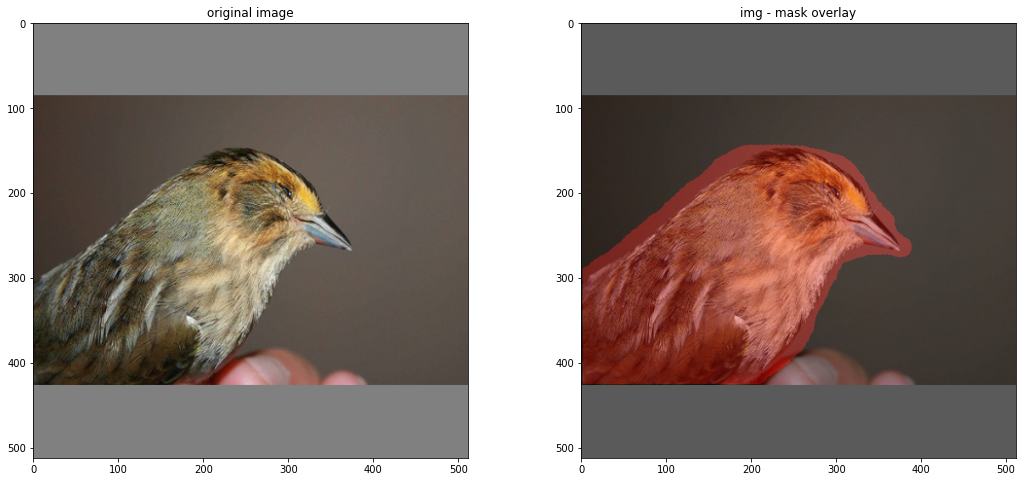

In [16]:
visualize_image_mask(Minmax(img), mask_gt)

### Visualize Prediction

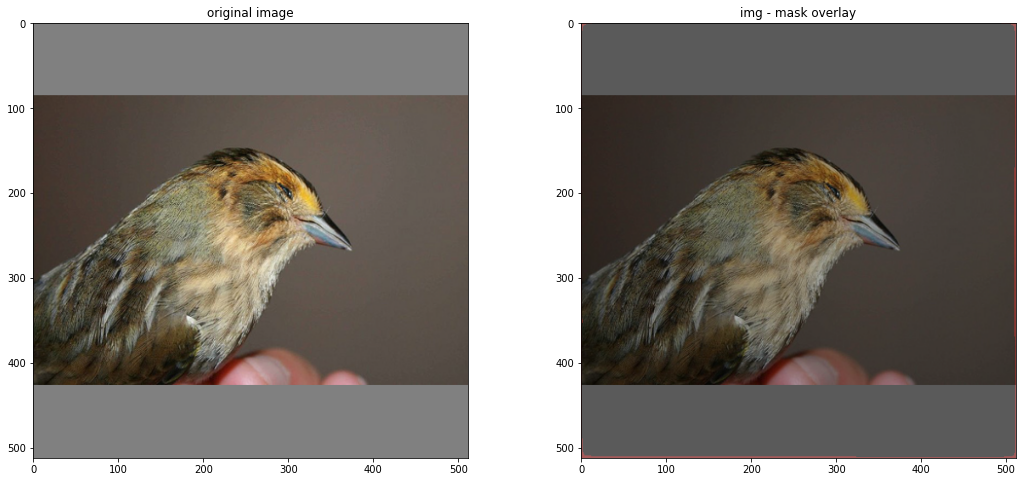

In [17]:
network = fe.Network(ops=[
    ModelOp(inputs='image', model=resunet50, outputs=["label_pred", "mask_pred"])
])

predictions = network.transform(result, mode="infer")
predicted_mask = predictions["mask_pred"].numpy() 
pred_mask = np.squeeze(predicted_mask)
pred_mask = np.round(pred_mask).astype(mask_gt.dtype)

visualize_image_mask(Minmax(img), pred_mask)